

                         Modelo predictivo Holtwinters                          
                                Aquino Rodríguez                                
                                      2025                                      




MAE: 3,719,941
RMSE: 5,342,086
MAPE: 1.52%




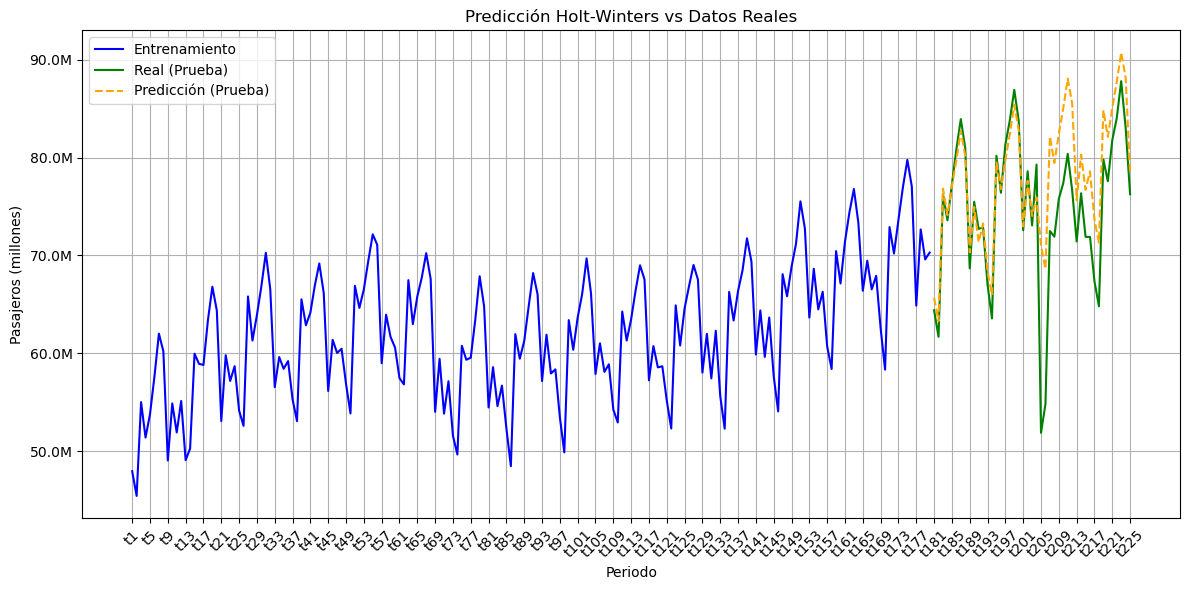

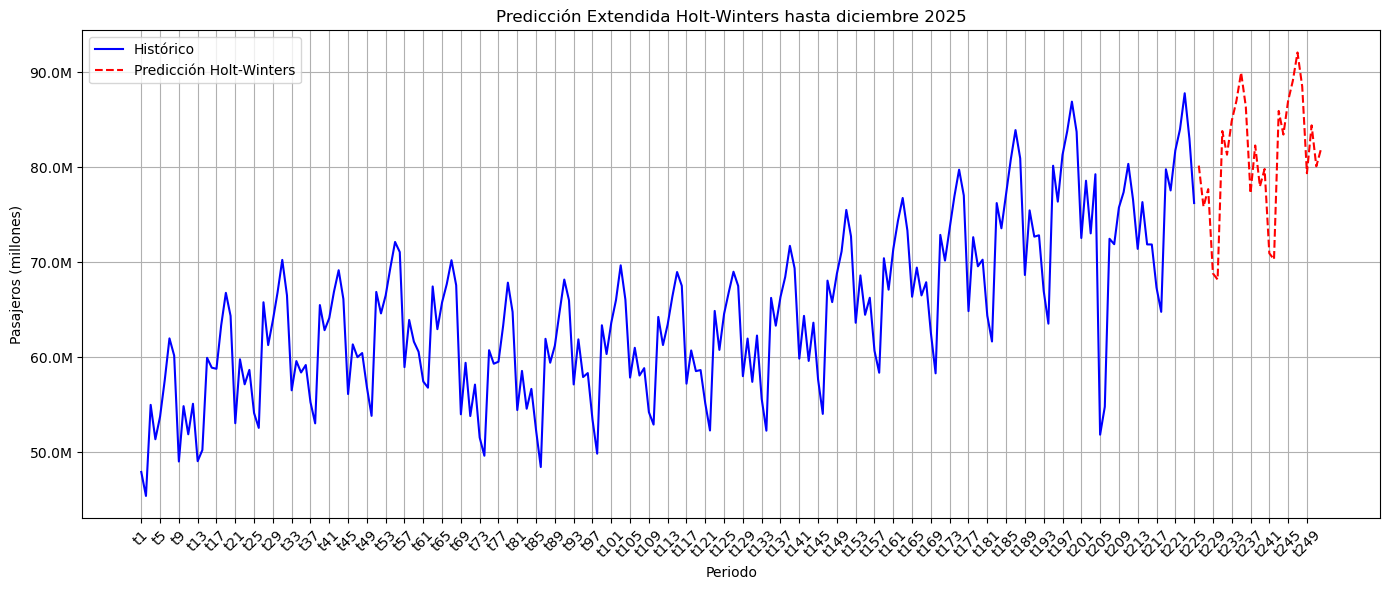

          Año Periodo Pronóstico_Pax_Millones
0  2023-10-01    t226                   80.2M
1  2023-11-01    t227                   75.9M
2  2023-12-01    t228                   77.7M
3  2024-01-01    t229                   68.8M
4  2024-02-01    t230                   68.2M
5  2024-03-01    t231                   83.8M
6  2024-04-01    t232                   81.3M
7  2024-05-01    t233                   84.9M
8  2024-06-01    t234                   87.0M
9  2024-07-01    t235                   90.0M
10 2024-08-01    t236                   86.4M
11 2024-09-01    t237                   77.3M
12 2024-10-01    t238                   82.3M
13 2024-11-01    t239                   78.0M
14 2024-12-01    t240                   79.8M
15 2025-01-01    t241                   71.0M
16 2025-02-01    t242                   70.3M
17 2025-03-01    t243                   85.9M
18 2025-04-01    t244                   83.5M
19 2025-05-01    t245                   87.0M
20 2025-06-01    t246             

In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
print()
print()
ancho = 80

# Códigos ANSI para color
amarillo = "\033[94m"
reset = "\033[0m"

print(amarillo + 'Modelo predictivo Holtwinters'.center(ancho) + reset)
print(amarillo + 'Aquino Rodríguez'.center(ancho) + reset)
print(amarillo + '2025'.center(ancho) + reset)
print()
print()
warnings.simplefilter("ignore")

# Cargar y preparar datos
df = pd.read_csv("air_traffic_final.csv")
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df.set_index('Date', inplace=True)
df = df.asfreq('MS')
df = df.sort_index()

# Excluir 2020 y 2021
df = df[~df.index.year.isin([2020, 2021])]

# Crear columna de periodo tipo t1, t2, ..., tn
df = df.copy()
df['Periodo'] = ['t' + str(i + 1) for i in range(len(df))]

ts = df['Pax']

# Separar en entrenamiento (80%) y prueba (20%)
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Ajustar modelo Holt-Winters
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Predicción
pred = fit.forecast(len(test))

# Evaluación
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

print()
print()
print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAPE: {mape:.2f}%")
print()
print()

# Función para formato de millones
def millones(x, pos):
    return f'{x * 1e-6:.1f}M'

# Periodos para gráfico
periodos_train = df['Periodo'][:train_size]
periodos_test = df['Periodo'][train_size:]

# Gráfica: predicción vs datos reales (ticks cada 4 meses)
plt.figure(figsize=(12, 6))
plt.plot(periodos_train, train.values, label='Entrenamiento', color='blue')
plt.plot(periodos_test, test.values, label='Real (Prueba)', color='green')
plt.plot(periodos_test, pred.values, label='Predicción (Prueba)', color='orange', linestyle='--')
plt.title('Predicción Holt-Winters vs Datos Reales')
plt.xlabel('Periodo')
plt.ylabel('Pasajeros (millones)')
plt.xticks(ticks=range(0, len(df), 4), labels=df['Periodo'].iloc[::4], rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millones))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Reentrenar con toda la serie
model_full = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12)
fit_full = model_full.fit()

# Fechas futuras
last_date = ts.index[-1]
future_months = pd.date_range(start=last_date + pd.DateOffset(months=1), end='2025-12-01', freq='MS')

# Predicción extendida
forecast_extended = fit_full.forecast(len(future_months))

# Crear periodos extendidos tipo tN+1, tN+2, ..., tN+m
last_period_number = len(df)
periodos_futuros = ['t' + str(last_period_number + i + 1) for i in range(len(future_months))]

print()
print()

# Gráfico: histórico + predicción extendida
plt.figure(figsize=(14, 6))
plt.plot(df['Periodo'], ts.values, label='Histórico', color='blue')
plt.plot(periodos_futuros, forecast_extended, label='Predicción Holt-Winters', color='red', linestyle='--')
plt.title('Predicción Extendida Holt-Winters hasta diciembre 2025')
plt.xlabel('Periodo')
plt.ylabel('Pasajeros (millones)')
plt.xticks(ticks=range(0, len(df) + len(future_months), 4),
           labels=(df['Periodo'].tolist() + periodos_futuros)[::4], rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millones))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabla de pronóstico
forecast_df = pd.DataFrame({
    'Año': future_months,
    'Periodo': periodos_futuros,
    'Pronóstico_Pax': forecast_extended.values
})

forecast_df['Pronóstico_Pax_Millones'] = forecast_df['Pronóstico_Pax'] / 1e6
forecast_df['Pronóstico_Pax_Millones'] = forecast_df['Pronóstico_Pax_Millones'].map(lambda x: f'{x:.1f}M')

# Mostrar tabla
print(forecast_df[['Año', 'Periodo', 'Pronóstico_Pax_Millones']])
